In [57]:
# Import libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import OrderedDict
from sklearn.cluster import KMeans
import collections
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

## PCR

In [95]:
# load datasest
df_pcr = pd.read_excel("./data/IgM Rapid Test-IgM ELISA-3rd dataset (All are SARS-CoV-2 qPT-PCR positive).xlsx", header=0, comment="#")
# replace unknown with average age
known_age = df_pcr[df_pcr["Age"] != "Unknow."]
#known_age.boxplot("Age")
avg_age = round(known_age["Age"].mean())
df_pcr["Age"] = df_pcr["Age"].replace("Unknow.", avg_age)
# further cleanup
indexNames = df_pcr[df_pcr['IgM/Rt '] == 'no'].index
 
# Delete these row indexes from dataFrame
df_pcr.drop(indexNames , inplace=True)

# set age to numeric
df_pcr["Age"] = df_pcr["Age"].astype(int)

# bin ages
df_pcr["Age bin"] = pd.cut(x=df_pcr['Age'], 
                       bins=[9, 20, 29, 39, 49, 59, 69, 79, 89], 
                       labels=['10s', '20s', '30s', '40s', '50s','60s', '70s', '80s'])
df_pcr= df_pcr.convert_dtypes()

# create target column
def encode_symptoms(row):
    wanted = row["Sym. grade"]
    if str(wanted) == "0":
        return 0
    return 1

df_pcr["target"] = df_pcr.apply(encode_symptoms, axis=1)


# create target column
def encode_symptoms(row):
    wanted = row["Sym. grade"]
    if str(wanted) == "0":
        return "no"
    return "yes"
df_pcr["symptoms_presence"] = df_pcr.apply(encode_symptoms, axis=1)

# create fold column
def encode_fold_change_igG(row):
    wanted = row["IgG/Rt "]
    if wanted == 0:
        fc = math.log10(1)
        return round(fc, 1)
    fc = round(math.log10(wanted), 1)
    return fc

df_pcr["fold_change_IgG"] = df_pcr.apply(encode_fold_change_igG, axis=1)

def encode_fold_change_igM(row):
    wanted = row["IgM/Rt "]
    if wanted == 0:
        fc = math.log10(1)
        return round(fc, 1)
    fc = round(math.log10(wanted), 1)
    return fc
df_pcr["fold_change_IgM"] = df_pcr.apply(encode_fold_change_igM, axis=1)



len(df_pcr)

45

In [96]:
df_pcr["IgM fold bin"] = pd.cut(x=df_pcr['fold_change_IgM'],
                       bins=[-0.9, 0, 0.7, 1, 1.7, 2.5], 
                       labels=['0f', '0.7f', '1f', '1.7f', '2f'])

In [97]:
df_pcr["IgG fold bin"] = pd.cut(x=df_pcr["fold_change_IgG"], 
                       bins=[-0.9, 0, 0.7, 1, 1.7, 2.5], 
                       labels=['0f', '0.7f', '1f', '1.7f', '2f'])

In [98]:
df_pcr_symptomatic = df_pcr[df_pcr["target"] == 1]
df_wanted_cols = df_pcr_symptomatic[["fold_change_IgG","fold_change_IgM"]]
df_wanted_cols.columns = ["IgG", "IgM"]

## Antibody

In [103]:
# load datasest
df_antibody = pd.read_excel("./data/IgM-IgG_ELISA_Rapid_Test_Symptoms.xlsx", header=0, comment="#")

# further cleanup
indexNames = df_antibody[df_antibody['Age'] == 'NS'].index
 
# Delete these row indexes from dataFrame
df_antibody.drop(indexNames , inplace=True)

# set age to numeric
df_antibody["Age"] = df_antibody["Age"].astype(int)

# bin ages
df_antibody["Age bin"] = pd.cut(x=df_antibody['Age'], 
                       bins=[10, 20, 29, 39, 49, 59, 69, 79, 89], 
                       labels=['10s', '20s', '30s', '40s', '50s','60s', '70s', '80s'])

# remove empty cells
df_antibody = df_antibody.dropna(axis=0)

df_antibody = df_antibody.convert_dtypes()

# create class column
def get_class(row):
    wanted = row["lab-ID"]
    return wanted.split("-")[0]

df_antibody["status"] = df_antibody.apply(get_class, axis=1)

# change N in iG/Rt column to 0
def replace_N(row):
    wanted = row["IgG/Rt "]
    if wanted == "N":
        return 0
    return wanted

df_antibody["IgG/Rt "] = df_antibody.apply(replace_N, axis=1)

# create target column
def encode_symptoms(row):
    wanted = row["Symptoms"]
    if str(wanted) == "no":
        return 0
    return 1

df_antibody["target"] = df_antibody.apply(encode_symptoms, axis=1)

# create fold column
def encode_rt_fold_change_igG(row):
    wanted = row["IgG/Rt "]
    if wanted == 0:
        fc = math.log10(1)
        return round(fc, 1)
    fc = round(math.log10(wanted), 1)
    return fc

df_antibody["rt_fold_change_IgG"] = df_antibody.apply(encode_rt_fold_change_igG, axis=1)

def encode_rt_fold_change_igM(row):
    wanted = row["IgM/Rt "]
    if wanted == 0:
        fc = math.log10(1)
        return round(fc, 1)
    fc = round(math.log10(wanted), 1)
    return fc

df_antibody["rt_fold_change_IgM"] = df_antibody.apply(encode_rt_fold_change_igM, axis=1)

# create fold column
def encode_fold_change_igG(row):
    wanted = row["IgG/ODs"]
    fc = (float(wanted)/0.542) - 1
    return fc

df_antibody["fold_change_IgG"] = df_antibody.apply(encode_fold_change_igG, axis=1)

def encode_fold_change_igM(row):
    wanted = row["IgM/ODs"]
    fc = (float(wanted)/0.498) - 1
    return fc
df_antibody["fold_change_IgM"] = df_antibody.apply(encode_fold_change_igM, axis=1)


len(df_antibody)

89

In [104]:
df_antibody["IgM rt fold bin"] = pd.cut(x=df_antibody['rt_fold_change_IgM'],
                       bins=[-0.9, 0, 0.7, 1, 1.7, 2.5], 
                       labels=['0f', '0.7f', '1f', '1.7f', '2f'])
df_antibody["IgM fold bin"] = pd.cut(x=df_antibody['fold_change_IgM'], 
                       bins=[-0.9, 0, 0.5, 1, 1.5, 2, 2.5, 3], 
                       labels=['bfc', '0.5fc', '1fc', '1.5fc', '2fc', '2.5fc','3fc'])

In [105]:
df_antibody["IgG rt fold bin"] = pd.cut(x=df_antibody["rt_fold_change_IgG"], 
                       bins=[-0.9, 0, 0.7, 1, 1.7, 2.5], 
                       labels=['0f', '0.7f', '1f', '1.7f', '2f'])
df_antibody["IgG fold bin"] = pd.cut(x=df_antibody['fold_change_IgG'], 
                       bins=[-0.9, 0, 0.5, 1, 1.5, 2, 2.5, 3], 
                       labels=['bfc', '0.5fc', '1fc', '1.5fc', '2fc', '2.5fc','3fc'])

In [106]:
df_antibody_symptomatic = df_antibody[df_antibody["target"] == 1]
df_wanted_cols_rt = df_antibody_symptomatic[["rt_fold_change_IgG","rt_fold_change_IgM"]]
df_wanted_cols_el = df_antibody_symptomatic[["fold_change_IgG","fold_change_IgM"]]
df_wanted_cols_el.columns = ["IgG", "IgM"]
df_wanted_cols_rt.columns = ["IgG", "IgM"]

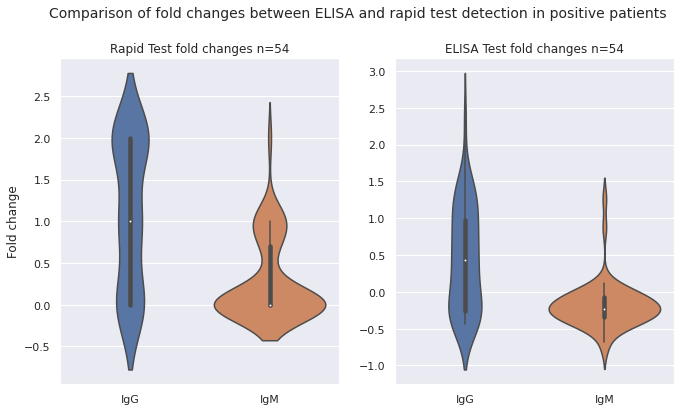

In [113]:
fig, axs = plt.subplots(ncols=2, figsize=(11,6))
ax = sns.violinplot(data=df_wanted_cols_rt, ax=axs[0])
ax.set(ylabel="Fold change")
ax = sns.violinplot(data=df_wanted_cols_el, ax=axs[1])
#ax.set(ylabel="Fold change")
axs[0].set_title('Rapid Test fold changes n={}'.format(len(df_wanted_cols_rt)))
axs[1].set_title('ELISA Test fold changes n={}'.format(len(df_wanted_cols_el)))
plt.suptitle("Comparison of fold changes between ELISA and rapid test detection in positive patients", fontsize=14, y=1)
fig.savefig("plots/comparison_of_fold_change_ELISA_and_RT.png")

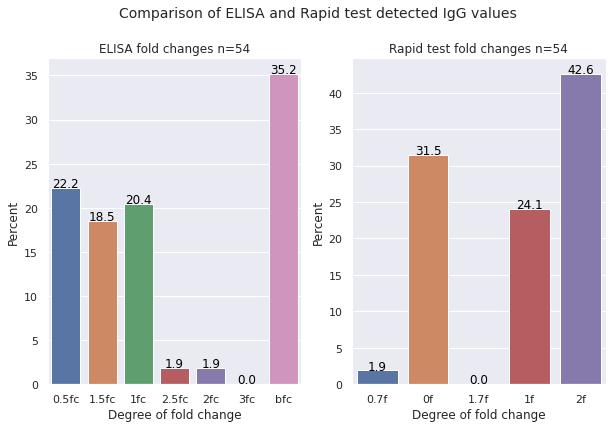

In [114]:
fig, axs = plt.subplots(ncols=2, figsize=(10,6))
d = dict(df_antibody_symptomatic["IgG fold bin"].value_counts(normalize=True).mul(100).round(1))
count_dict = collections.OrderedDict(sorted(d.items()))
ax = sns.barplot(y=list(count_dict.values()), x=list(count_dict.keys()), ax=axs[0])
ax.set(ylabel="Percent")
ax.set(xlabel="Degree of fold change")
   # ax.legend(title='Symptoms presence', bbox_to_anchor=(1.05, 1), loc='upper left')
for index, text in enumerate(ax.get_xticklabels()):
    label = count_dict[text.get_text()]
    ax.text(index,
            label + 0.1,
            str(label),
            horizontalalignment='center',
            size='medium',
            color='black',
            weight='normal')
d = dict(df_antibody_symptomatic["IgG rt fold bin"].value_counts(normalize=True).mul(100).round(1))
count_dict = collections.OrderedDict(sorted(d.items()))
ax = sns.barplot(y=list(count_dict.values()), x=list(count_dict.keys()), ax=axs[1])
ax.set(ylabel="Percent")
ax.set(xlabel="Degree of fold change")
   # ax.legend(title='Symptoms presence', bbox_to_anchor=(1.05, 1), loc='upper left')
for index, text in enumerate(ax.get_xticklabels()):
    label = count_dict[text.get_text()]
    ax.text(index,
            label + 0.1,
            str(label),
            horizontalalignment='center',
            size='medium',
            color='black',
            weight='normal')
axs[0].set_title('ELISA fold changes n=54')
axs[1].set_title('Rapid test fold changes n=54')
plt.suptitle("Comparison of ELISA and Rapid test detected IgG values", fontsize=14, y=1)
fig.savefig("plots/comparison_of_fold_change_ELISA_and_RT_IgG.png")

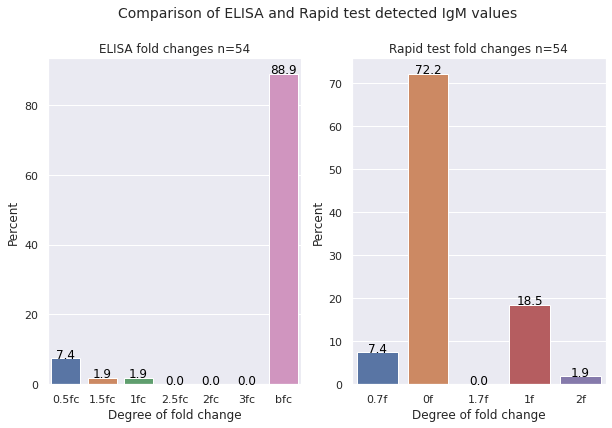

In [115]:
fig, axs = plt.subplots(ncols=2, figsize=(10,6))
d = dict(df_antibody_symptomatic["IgM fold bin"].value_counts(normalize=True).mul(100).round(1))
count_dict = collections.OrderedDict(sorted(d.items()))
ax = sns.barplot(y=list(count_dict.values()), x=list(count_dict.keys()), ax=axs[0])
ax.set(ylabel="Percent")
ax.set(xlabel="Degree of fold change")
   # ax.legend(title='Symptoms presence', bbox_to_anchor=(1.05, 1), loc='upper left')
for index, text in enumerate(ax.get_xticklabels()):
    label = count_dict[text.get_text()]
    ax.text(index,
            label + 0.1,
            str(label),
            horizontalalignment='center',
            size='medium',
            color='black',
            weight='normal')
d = dict(df_antibody_symptomatic["IgM rt fold bin"].value_counts(normalize=True).mul(100).round(1))
count_dict = collections.OrderedDict(sorted(d.items()))
ax = sns.barplot(y=list(count_dict.values()), x=list(count_dict.keys()), ax=axs[1])
ax.set(ylabel="Percent")
ax.set(xlabel="Degree of fold change")
   # ax.legend(title='Symptoms presence', bbox_to_anchor=(1.05, 1), loc='upper left')
for index, text in enumerate(ax.get_xticklabels()):
    label = count_dict[text.get_text()]
    ax.text(index,
            label + 0.1,
            str(label),
            horizontalalignment='center',
            size='medium',
            color='black',
            weight='normal')
axs[0].set_title('ELISA fold changes n=54')
axs[1].set_title('Rapid test fold changes n=54')
plt.suptitle("Comparison of ELISA and Rapid test detected IgM values", fontsize=14, y=1)
fig.savefig("plots/comparison_of_fold_change_ELISA_and_RT_IgM.png")